# Anomaly Detection - Activity 2 NSIOT
# Network Solutions for IoT
# Albert Marquillas - September 2025
# Group B - Eric Ramirez & Jordi Nadeu

## Objectives

This practical activity focuses on unsupervised learning techniques for anomaly detection. Students will work with time series data from industrial systems, exploring how to identify unusual patterns or outliers without labeled examples.
We will use methods such as Isolation Forest and DBSCAN to detect anomalies in sensor data.

In [2]:
## Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.fft import fft
import kagglehub
import os

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

### 5.0 Download and loading dataset

In [3]:
# Download NAB dataset from Kaggle
path = kagglehub.dataset_download("boltzmannbrain/nab")

# Find the ambient temperature system failure dataset
data_file = None
for root, dirs, files in os.walk(path):
    for file in files:
        if 'ambient_temperature_system_failure.csv' in file:
            data_file = os.path.join(root, file)
            break
    if data_file:
        break

print(f"Loading data from: {os.path.basename(data_file)}")

Loading data from: ambient_temperature_system_failure.csv


## 5.1 Data Exploration


 Dataset Info:
Dataset shape: (7267, 2)
Number of samples: 7267
Number of features: 2

 First 5 rows:
             timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551

 Plotting time series data...


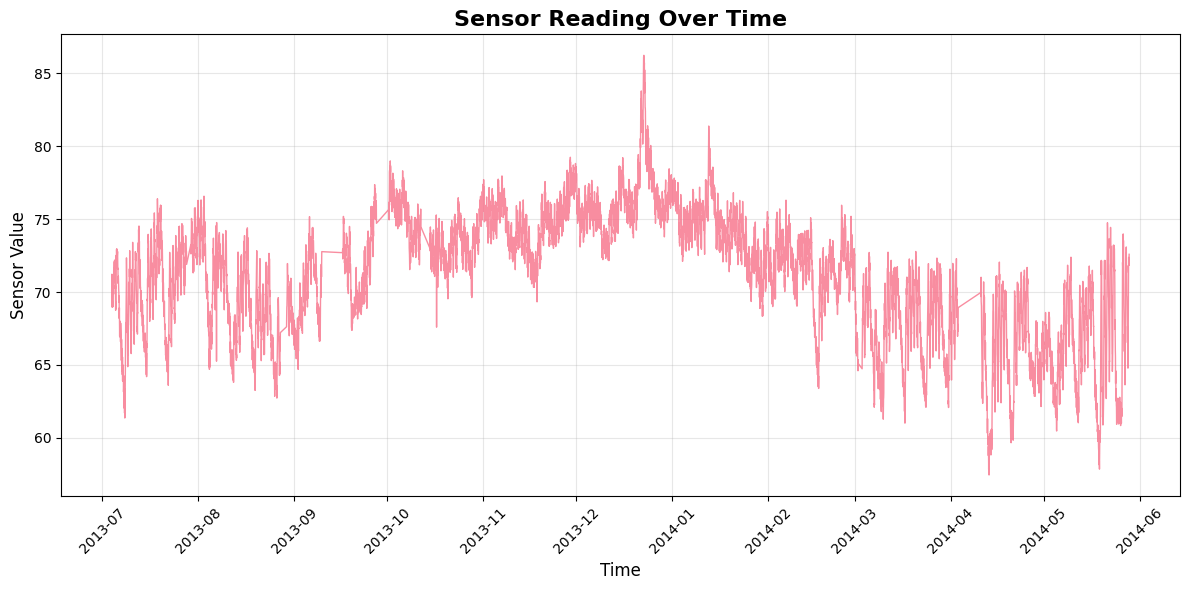

In [4]:
# Load the dataset
df = pd.read_csv(data_file)

print("\n Dataset Info:")
print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

# Display first few rows
print("\n First 5 rows:")
print(df.head(5))
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plot the time series to visually inspect for potential anomalies
print("\n Plotting time series data...")
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], linewidth=1, alpha=0.8)
plt.title('Sensor Reading Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sensor Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5.2 Feature Engineering

In [5]:
# Compute derived features
window_size = 10

print("Creating engineered features...")
print(f"Using rolling window size: {window_size}")

# Rolling statistics
df['rolling_mean'] = df['value'].rolling(window=window_size).mean()
df['rolling_std'] = df['value'].rolling(window=window_size).std()
df['diff'] = df['value'].diff()

# Drop NaN values
df_clean = df.dropna().copy()

print(f"\n Feature Engineering Results:")
print(f"Original dataset shape: {df.shape}")
print(f"After feature engineering: {df_clean.shape}")
print(f"Features created: rolling_mean, rolling_std, diff")

Creating engineered features...
Using rolling window size: 10

 Feature Engineering Results:
Original dataset shape: (7267, 5)
After feature engineering: (7258, 5)
Features created: rolling_mean, rolling_std, diff


## 5.3 Anomaly Detection with Isolation Forest

Features used for Isolation Forest: ['value', 'rolling_mean', 'rolling_std', 'diff']
Feature matrix shape: (7258, 4)
Training Isolation Forest with contamination rate: 0.01

 Isolation Forest Results:
Number of anomalies detected: 73
Percentage of anomalies: 1.01%


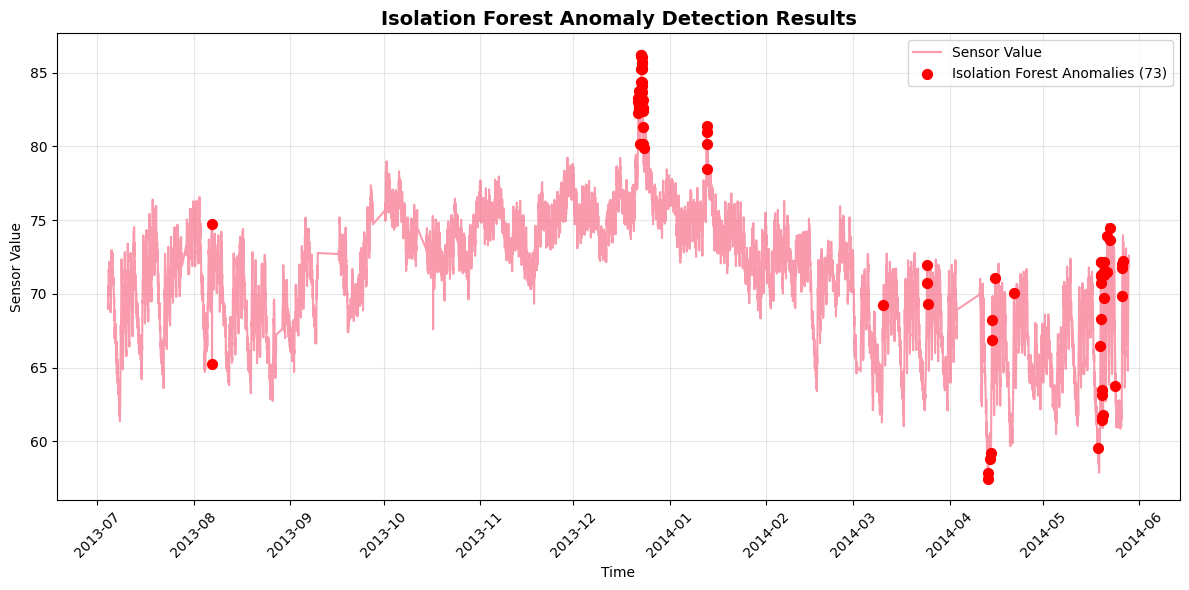

In [6]:
# Select features for anomaly detection
feature_columns = ['value', 'rolling_mean', 'rolling_std', 'diff']
features = df_clean[feature_columns]

print(f"Features used for Isolation Forest: {feature_columns}")
print(f"Feature matrix shape: {features.shape}")

# Fit Isolation Forest model
contamination_rate = 0.01  # Expect 1% of data to be anomalous
print(f"Training Isolation Forest with contamination rate: {contamination_rate}")

isolation_forest = IsolationForest(
    contamination=contamination_rate,
    random_state=42,
    n_estimators=100
)

# Fit and predict
df_clean['anomaly'] = isolation_forest.fit_predict(features)
df_clean['anomaly_score'] = isolation_forest.score_samples(features)

# Count anomalies
n_anomalies_if = (df_clean['anomaly'] == -1).sum()
anomaly_percentage_if = (n_anomalies_if / len(df_clean)) * 100

print(f"\n Isolation Forest Results:")
print(f"Number of anomalies detected: {n_anomalies_if}")
print(f"Percentage of anomalies: {anomaly_percentage_if:.2f}%")
#print(f"Anomaly score range: {df_clean['anomaly_score'].min():.3f} to {df_clean['anomaly_score'].max():.3f}")

# Plot Isolation Forest results
plt.figure(figsize=(12, 6))

# Main time series with anomalies
plt.plot(df_clean['timestamp'], df_clean['value'], label='Sensor Value', alpha=0.7)
anomaly_points = df_clean[df_clean['anomaly'] == -1]
plt.scatter(anomaly_points['timestamp'], anomaly_points['value'],
           color='red', s=50, label=f'Isolation Forest Anomalies ({n_anomalies_if})', zorder=5)
plt.title('Isolation Forest Anomaly Detection Results', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

## 5.4 Anomaly Detection with DBSCAN

Features scaled for DBSCAN
Original feature means: [71.244 71.243  0.986  0.   ]
Scaled feature means: [-0. -0.  0.  0.]
Scaled feature stds: [1. 1. 1. 1.]
Training DBSCAN with eps=0.5, min_samples=5

 DBSCAN Results:
Number of clusters found: 6
Number of anomalies (noise points): 261
Percentage of anomalies: 3.60%
Cluster labels: [-1  0  1  2  3  4  5]


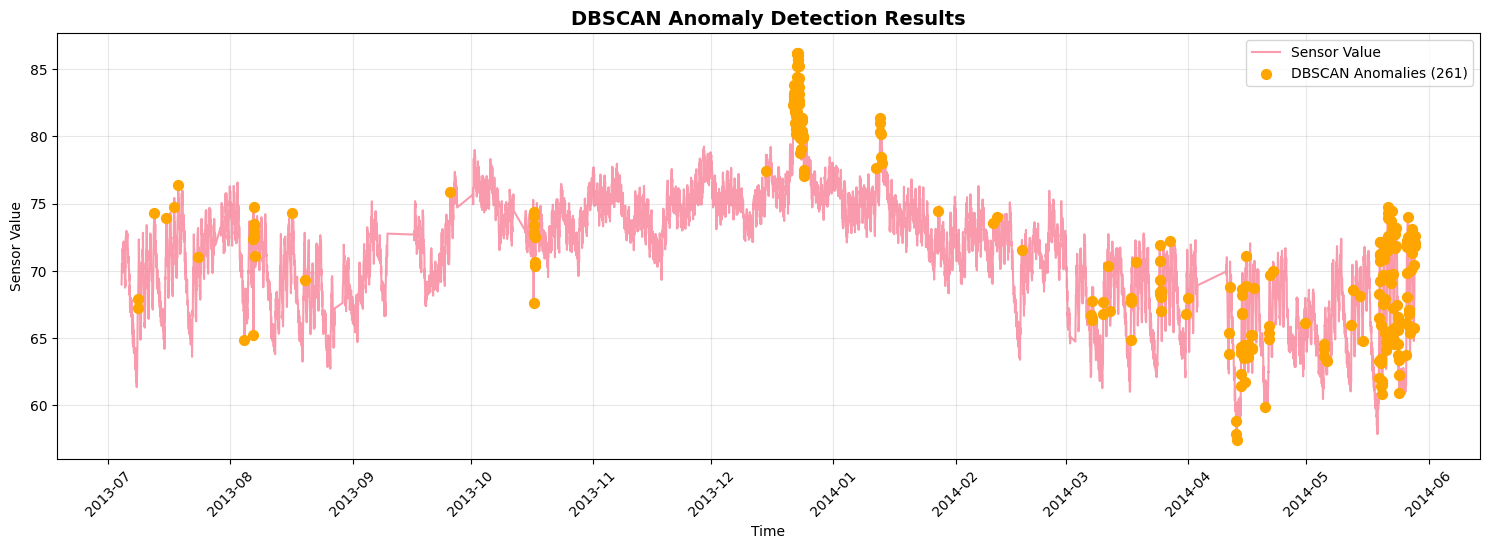

In [7]:
# Scale the features for DBSCAN
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

print(f"Features scaled for DBSCAN")
print(f"Original feature means: {features.mean().values.round(3)}")
print(f"Scaled feature means: {scaled_features.mean(axis=0).round(3)}")
print(f"Scaled feature stds: {scaled_features.std(axis=0).round(3)}")

# Fit DBSCAN model
eps = 0.5  # Maximum distance between samples in the same neighborhood
min_samples = 5  # Minimum number of samples in a neighborhood

print(f"Training DBSCAN with eps={eps}, min_samples={min_samples}")

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_clean['dbscan_label'] = dbscan.fit_predict(scaled_features)


# Analyze DBSCAN results
unique_labels = np.unique(df_clean['dbscan_label'])
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_anomalies_dbscan = (df_clean['dbscan_label'] == -1).sum()
anomaly_percentage_dbscan = (n_anomalies_dbscan / len(df_clean)) * 100

print(f"\n DBSCAN Results:")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of anomalies (noise points): {n_anomalies_dbscan}")
print(f"Percentage of anomalies: {anomaly_percentage_dbscan:.2f}%")
print(f"Cluster labels: {unique_labels}")

# Plot DBSCAN results
plt.figure(figsize=(15, 10))

# Main time series with DBSCAN anomalies
plt.subplot(2, 1, 1)
plt.plot(df_clean['timestamp'], df_clean['value'], label='Sensor Value', alpha=0.7)
dbscan_anomalies = df_clean[df_clean['dbscan_label'] == -1]
plt.scatter(dbscan_anomalies['timestamp'], dbscan_anomalies['value'],
           color='orange', s=50, label=f'DBSCAN Anomalies ({n_anomalies_dbscan})', zorder=5)
plt.title('DBSCAN Anomaly Detection Results', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 5.5 Comparison and Discussion

Comparison of Anomaly Detection Methods:

Isolation Forest anomalies: 73
DBSCAN anomalies: 261

 Agreement Analysis:
Anomalies detected by both methods: 68
Anomalies detected by either method: 266
Anomalies detected only by Isolation Forest: 5
Anomalies detected only by DBSCAN: 193


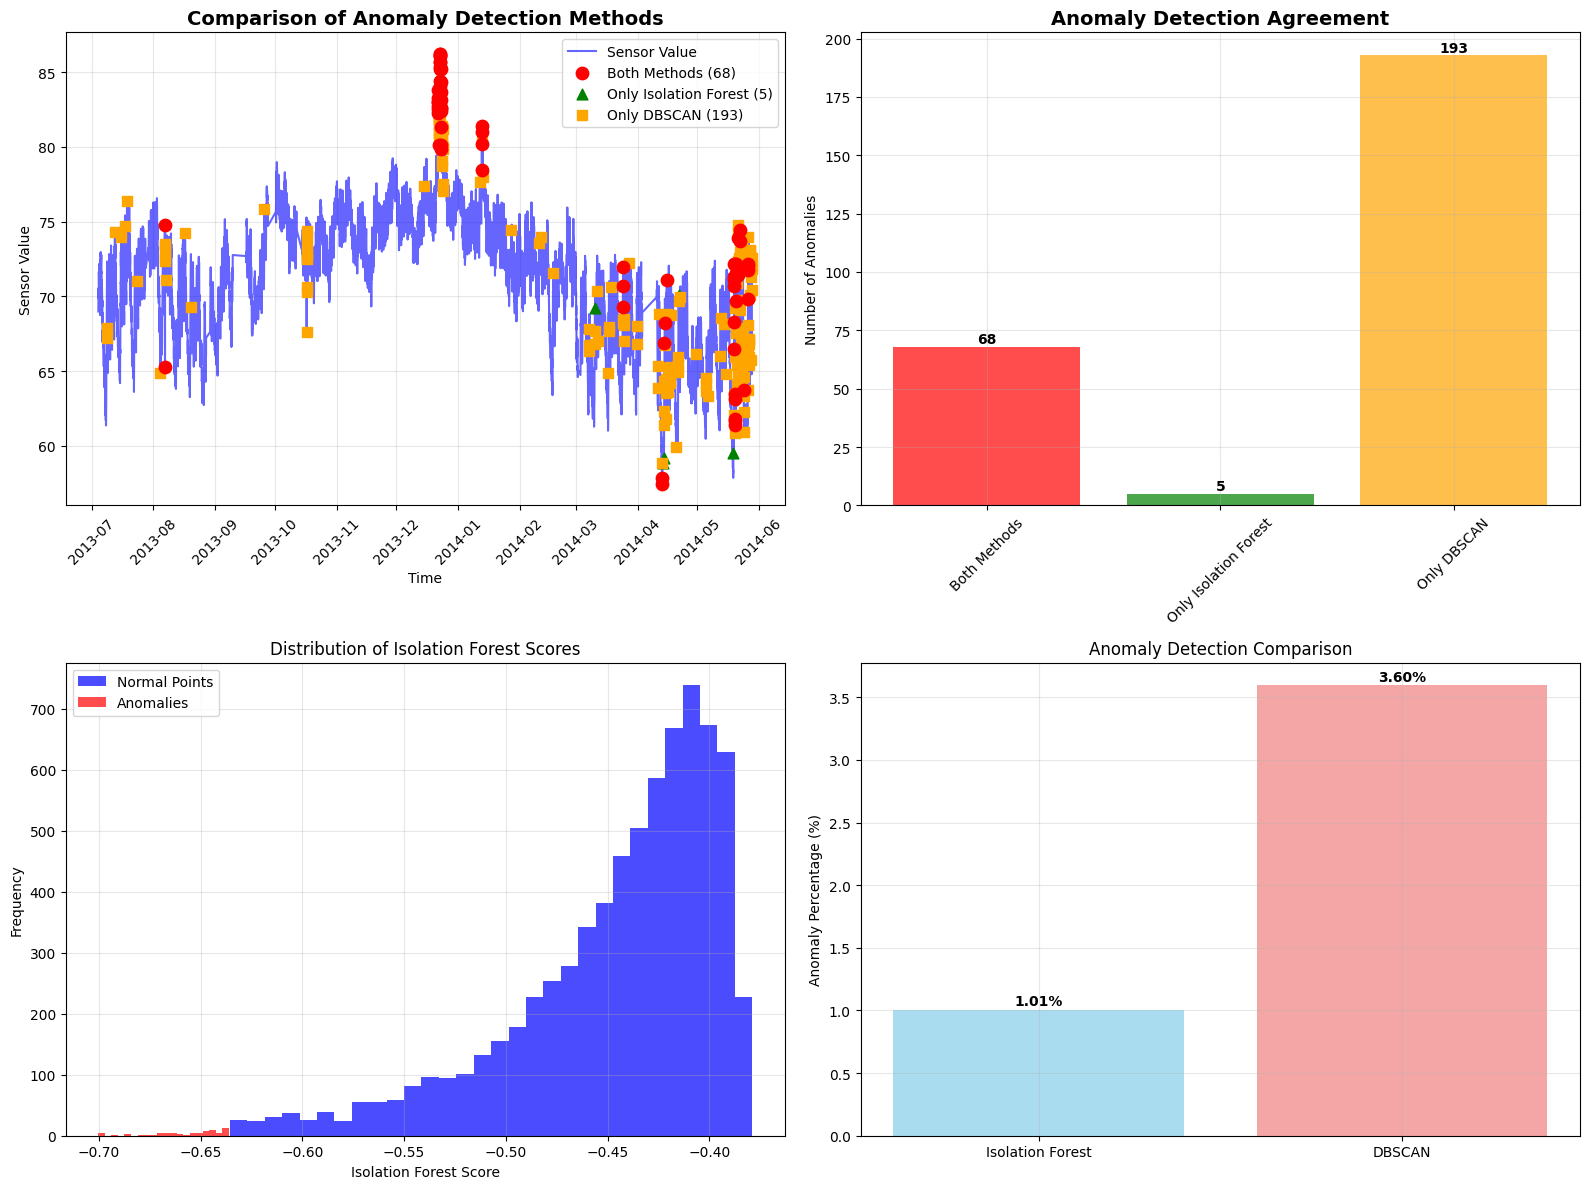


STATISTICAL ANALYSIS OF DETECTED ANOMALIES

 Isolation Forest Anomaly Statistics:
Mean value of anomalies: 74.895
Std value of anomalies: 8.578
Mean anomaly score: -0.657

 DBSCAN Anomaly Statistics:
Mean value of anomalies: 71.678
Std value of anomalies: 6.819

 Normal Data Statistics (detected as normal by both methods):
Mean value: 71.234
Std value: 4.117
Count: 6992


In [8]:
# Create comparison of both methods
df_clean['both_anomaly'] = ((df_clean['anomaly'] == -1) & (df_clean['dbscan_label'] == -1)).astype(int)
df_clean['either_anomaly'] = ((df_clean['anomaly'] == -1) | (df_clean['dbscan_label'] == -1)).astype(int)
df_clean['only_isolation_forest'] = ((df_clean['anomaly'] == -1) & (df_clean['dbscan_label'] != -1)).astype(int)
df_clean['only_dbscan'] = ((df_clean['anomaly'] != -1) & (df_clean['dbscan_label'] == -1)).astype(int)

# Calculate agreement statistics
n_both = df_clean['both_anomaly'].sum()
n_either = df_clean['either_anomaly'].sum()
n_only_if = df_clean['only_isolation_forest'].sum()
n_only_dbscan = df_clean['only_dbscan'].sum()

print("Comparison of Anomaly Detection Methods:")
print(f"\nIsolation Forest anomalies: {n_anomalies_if}")
print(f"DBSCAN anomalies: {n_anomalies_dbscan}")
print(f"\n Agreement Analysis:")
print(f"Anomalies detected by both methods: {n_both}")
print(f"Anomalies detected by either method: {n_either}")
print(f"Anomalies detected only by Isolation Forest: {n_only_if}")
print(f"Anomalies detected only by DBSCAN: {n_only_dbscan}")

# Comprehensive comparison visualization
plt.figure(figsize=(16, 12))

# Combined anomaly detection results
plt.subplot(2, 2, 1)
plt.plot(df_clean['timestamp'], df_clean['value'], alpha=0.6, color='blue', label='Sensor Value')

# Plot different types of anomalies
if n_both > 0:
    both_points = df_clean[df_clean['both_anomaly'] == 1]
    plt.scatter(both_points['timestamp'], both_points['value'],
               color='red', s=80, marker='o', label=f'Both Methods ({n_both})', zorder=6)

if n_only_if > 0:
    if_only_points = df_clean[df_clean['only_isolation_forest'] == 1]
    plt.scatter(if_only_points['timestamp'], if_only_points['value'],
               color='green', s=60, marker='^', label=f'Only Isolation Forest ({n_only_if})', zorder=5)

if n_only_dbscan > 0:
    dbscan_only_points = df_clean[df_clean['only_dbscan'] == 1]
    plt.scatter(dbscan_only_points['timestamp'], dbscan_only_points['value'],
               color='orange', s=60, marker='s', label=f'Only DBSCAN ({n_only_dbscan})', zorder=5)

plt.title('Comparison of Anomaly Detection Methods', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Method agreement visualization
plt.subplot(2, 2, 2)
agreement_data = {
    'Both Methods': n_both,
    'Only Isolation Forest': n_only_if,
    'Only DBSCAN': n_only_dbscan
}
colors = ['red', 'green', 'orange']
bars = plt.bar(agreement_data.keys(), agreement_data.values(), color=colors, alpha=0.7)
plt.title('Anomaly Detection Agreement', fontsize=14, fontweight='bold')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)
for bar, value in zip(bars, agreement_data.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(value), ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3)

# Distribution of anomaly scores comparison
plt.subplot(2, 2, 3)
if n_anomalies_if > 0:
    normal_if_scores = df_clean[df_clean['anomaly'] == 1]['anomaly_score']
    anomaly_if_scores = df_clean[df_clean['anomaly'] == -1]['anomaly_score']

    plt.hist(normal_if_scores, bins=30, alpha=0.7, label='Normal Points', color='blue')
    plt.hist(anomaly_if_scores, bins=20, alpha=0.7, label='Anomalies', color='red')
    plt.xlabel('Isolation Forest Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Isolation Forest Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Method performance summary
plt.subplot(2, 2, 4)
comparison_summary = {
    'Method': ['Isolation Forest', 'DBSCAN'],
    'Anomalies': [n_anomalies_if, n_anomalies_dbscan],
    'Percentage': [anomaly_percentage_if, anomaly_percentage_dbscan]
}

bars = plt.bar(comparison_summary['Method'], comparison_summary['Percentage'],
               color=['skyblue', 'lightcoral'], alpha=0.7)
plt.title('Anomaly Detection Comparison')
plt.ylabel('Anomaly Percentage (%)')
plt.grid(True, alpha=0.3)
for bar, percentage in zip(bars, comparison_summary['Percentage']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{percentage:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical analysis of detected anomalies
print(f"\n{'='*60}")
print("STATISTICAL ANALYSIS OF DETECTED ANOMALIES")
print(f"{'='*60}")

if n_anomalies_if > 0:
    if_anomalies = df_clean[df_clean['anomaly'] == -1]
    print(f"\n Isolation Forest Anomaly Statistics:")
    print(f"Mean value of anomalies: {if_anomalies['value'].mean():.3f}")
    print(f"Std value of anomalies: {if_anomalies['value'].std():.3f}")
    print(f"Mean anomaly score: {if_anomalies['anomaly_score'].mean():.3f}")

if n_anomalies_dbscan > 0:
    dbscan_anomalies = df_clean[df_clean['dbscan_label'] == -1]
    print(f"\n DBSCAN Anomaly Statistics:")
    print(f"Mean value of anomalies: {dbscan_anomalies['value'].mean():.3f}")
    print(f"Std value of anomalies: {dbscan_anomalies['value'].std():.3f}")

# Normal data statistics for comparison
normal_data = df_clean[(df_clean['anomaly'] == 1) & (df_clean['dbscan_label'] != -1)]
if len(normal_data) > 0:
    print(f"\n Normal Data Statistics (detected as normal by both methods):")
    print(f"Mean value: {normal_data['value'].mean():.3f}")
    print(f"Std value: {normal_data['value'].std():.3f}")
    print(f"Count: {len(normal_data)}")

### Discuss the strengths and limitations of each method:

Based on the results from the notebook, the strengths and limitations of Isolation Forest and DBSCAN for this time series anomaly detection task are:

Isolation Forest:

    Strengths:
        It performed relatively well in identifying anomalies, detecting 73 instances with a contamination rate of 1%. Its  efficient and scales well to large datasets.
    Limitations:
        It detected fewer anomalies compared to DBSCAN (73 vs 261) and choosing the appropriate contamination parameter can be challenging.

DBSCAN:

    Strengths:
        It identified a larger number of potential anomalies (261) and it possible to be more sensitive to different types of outliers in this dataset.
    Limitations:
        It requires feature scaling, as shown in the code using StandardScaler and finding the optimal values can require experimentation and try error.
Comparison:
    We can say that each method capture different aspects of what constitutes anomaly in this dataset.
    Isolation Forest seems to focus on points that are far from the rest of the data in the feature space, while DBSCAN identifies points in low density regions.

### Reflect on practical industrial applications of these techniques:

Both Isolation Forest and DBSCAN have practical applications in industrial settings, especially for anomaly detection in time series data.
In these applications, the ability of unsupervised methods to work without labeled anomaly data is particularly valuable, as anomalies are often rare and unpredictable in industrial settings. The insights gained from these techniques can help improve efficiency, safety and reliability.

## 6. Optional extensions


 Extension 1: Analyzing another time series from NAB dataset
 Loading second dataset: machine_temperature_system_failure.csv

 Second Dataset Overview:
Dataset shape: (22695, 2)
Number of samples: 22695
Number of features: 2

 First 5 rows:
            timestamp      value
0 2013-12-02 21:15:00  73.967322
1 2013-12-02 21:20:00  74.935882
2 2013-12-02 21:25:00  76.124162
3 2013-12-02 21:30:00  78.140707
4 2013-12-02 21:35:00  79.329836


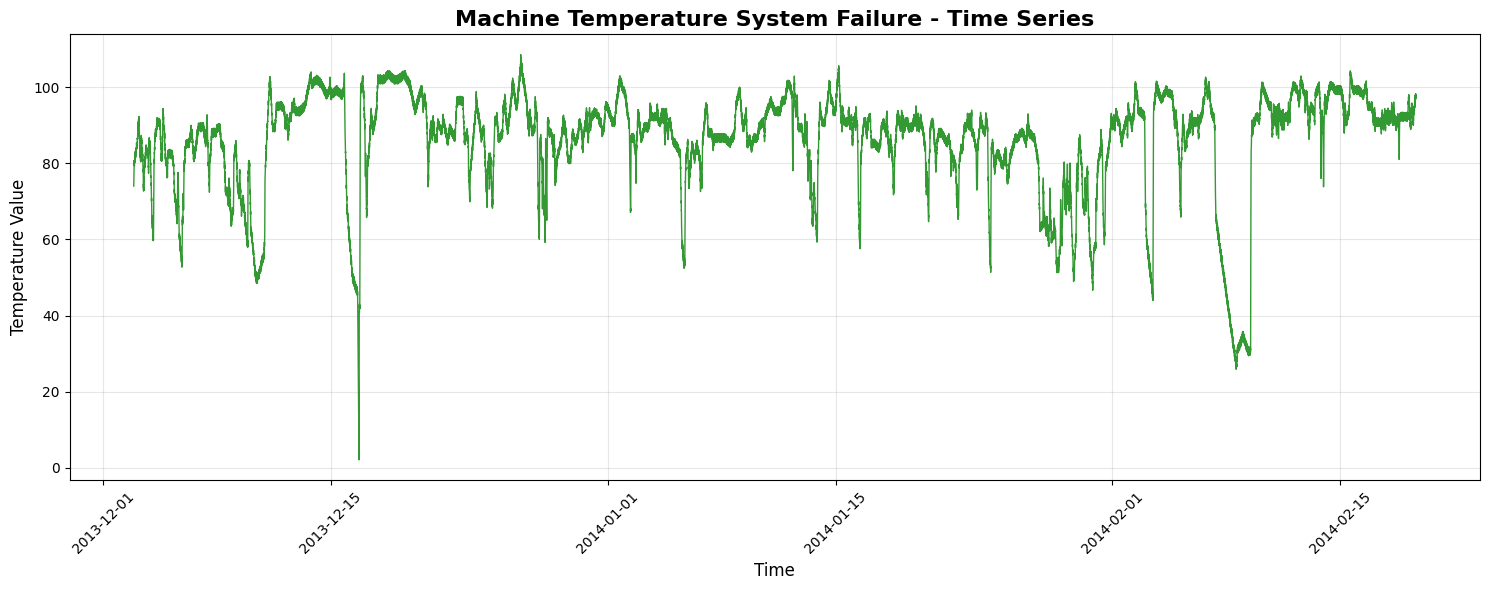


 Applying feature engineering to second dataset...

 Applying Isolation Forest to second dataset...
 Isolation Forest Results (Dataset 2):
Number of anomalies: 227 (1.00%)

 Applying DBSCAN to second dataset...
 DBSCAN Results (Dataset 2):
Number of anomalies: 310 (1.37%)


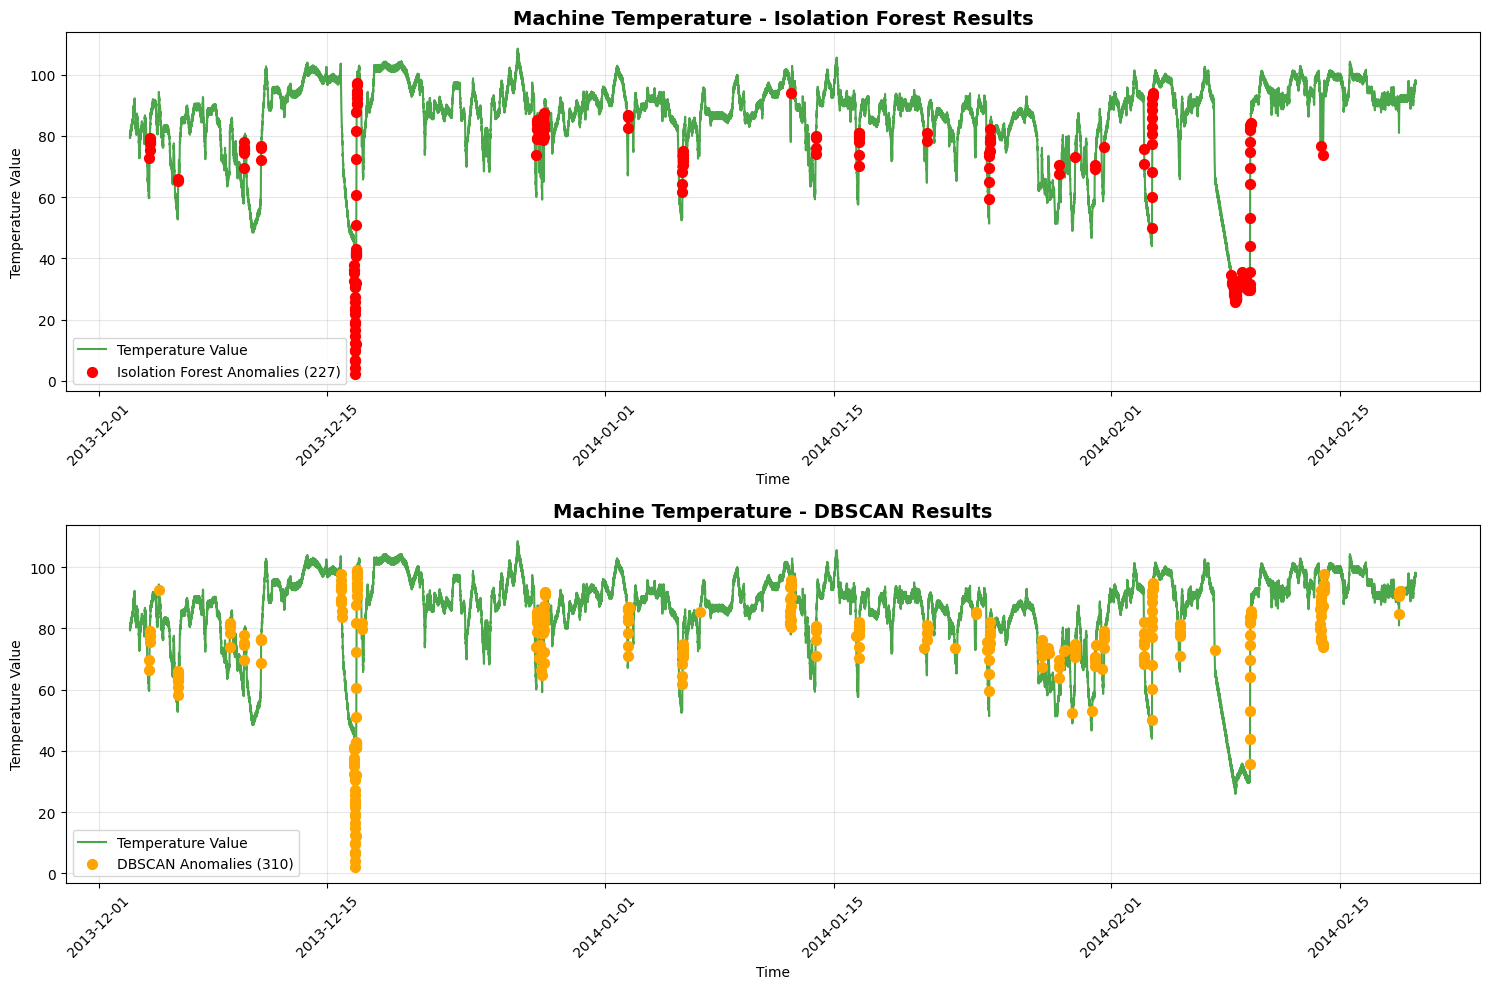


 Comparison between two time series:
            Dataset  IF Anomalies  IF %  DBSCAN Anomalies DBSCAN %
Ambient Temperature            73 1.01%               261    3.60%
Machine Temperature           227 1.00%               310    1.37%

 Extension 2: Tune hyperparameters

 Tuning contamination parameter for Isolation Forest:
   contamination  n_anomalies  percentage
0          0.005           37    0.509782
1          0.010           73    1.005787
2          0.020          146    2.011573
3          0.050          363    5.001378
4          0.100          726   10.002756

 Tuning eps and min_samples parameters for DBSCAN:
    eps  min_samples  n_clusters  n_anomalies  percentage
0   0.3            3          69          692    9.534307
1   0.3            5          17         1057   14.563241
2   0.3            7          17         1345   18.531276
3   0.3           10           6         1934   26.646459
4   0.5            3          11          187    2.576467
5   0.5           

In [29]:
# Extension 1: Try another time series from the NAB dataset
print("\n Extension 1: Analyzing another time series from NAB dataset")
print("=" * 50)

# Find and load machine_temperature_system_failure.csv
data_file_2 = None
for root, dirs, files in os.walk(path):
    for file in files:
        if 'machine_temperature_system_failure.csv' in file:
            data_file_2 = os.path.join(root, file)
            break
    if data_file_2:
        break


print(f" Loading second dataset: {os.path.basename(data_file_2)}")
df2 = pd.read_csv(data_file_2)

# Convert timestamp to datetime
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

print("\n Second Dataset Overview:")
print(f"Dataset shape: {df2.shape}")
print(f"Number of samples: {df2.shape[0]}")
print(f"Number of features: {df2.shape[1]}")

# Display first few rows
print("\n First 5 rows:")
print(df2.head(5))

# Plot the second time series
plt.figure(figsize=(15, 6))
plt.plot(df2['timestamp'], df2['value'], linewidth=1, alpha=0.8, color='green')
plt.title('Machine Temperature System Failure - Time Series', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature engineering for second dataset
print("\n Applying feature engineering to second dataset...")
df2['rolling_mean'] = df2['value'].rolling(window=window_size).mean()
df2['rolling_std'] = df2['value'].rolling(window=window_size).std()
df2['diff'] = df2['value'].diff()
df2_clean = df2.dropna().copy()
    
# Prepare features
features_2 = df2_clean[['value', 'rolling_mean', 'rolling_std', 'diff']]

# Apply Isolation Forest
print("\n Applying Isolation Forest to second dataset...")
isolation_forest_2 = IsolationForest(contamination=0.01, random_state=42, n_estimators=100)
df2_clean['anomaly'] = isolation_forest_2.fit_predict(features_2)
n_anomalies_if_2 = (df2_clean['anomaly'] == -1).sum()
anomaly_percentage_if_2 = (n_anomalies_if_2 / len(df2_clean)) * 100

print(f" Isolation Forest Results (Dataset 2):")
print(f"Number of anomalies: {n_anomalies_if_2} ({anomaly_percentage_if_2:.2f}%)")

# Apply DBSCAN
print("\n Applying DBSCAN to second dataset...")
scaler_2 = StandardScaler()
scaled_features_2 = scaler_2.fit_transform(features_2)
dbscan_2 = DBSCAN(eps=0.5, min_samples=5)
df2_clean['dbscan_label'] = dbscan_2.fit_predict(scaled_features_2)
n_anomalies_dbscan_2 = (df2_clean['dbscan_label'] == -1).sum()
anomaly_percentage_dbscan_2 = (n_anomalies_dbscan_2 / len(df2_clean)) * 100
    
print(f" DBSCAN Results (Dataset 2):")
print(f"Number of anomalies: {n_anomalies_dbscan_2} ({anomaly_percentage_dbscan_2:.2f}%)")
    
# Visualize results for second dataset
plt.figure(figsize=(15, 10))
   
plt.subplot(2, 1, 1)
plt.plot(df2_clean['timestamp'], df2_clean['value'], label='Temperature Value', alpha=0.7, color='green')
anomaly_points_2 = df2_clean[df2_clean['anomaly'] == -1]
plt.scatter(anomaly_points_2['timestamp'], anomaly_points_2['value'], 
               color='red', s=50, label=f'Isolation Forest Anomalies ({n_anomalies_if_2})', zorder=5)
plt.title('Machine Temperature - Isolation Forest Results', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Temperature Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
    
plt.subplot(2, 1, 2)
plt.plot(df2_clean['timestamp'], df2_clean['value'], label='Temperature Value', alpha=0.7, color='green')
dbscan_anomalies_2 = df2_clean[df2_clean['dbscan_label'] == -1]
plt.scatter(dbscan_anomalies_2['timestamp'], dbscan_anomalies_2['value'], 
            color='orange', s=50, label=f'DBSCAN Anomalies ({n_anomalies_dbscan_2})', zorder=5)
plt.title('Machine Temperature - DBSCAN Results', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Temperature Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()
    
# Compare results between two datasets
print("\n Comparison between two time series:")
comparison_datasets = pd.DataFrame({
    'Dataset': ['Ambient Temperature', 'Machine Temperature'],
    'IF Anomalies': [n_anomalies_if, n_anomalies_if_2],
    'IF %': [f'{anomaly_percentage_if:.2f}%', f'{anomaly_percentage_if_2:.2f}%'],
    'DBSCAN Anomalies': [n_anomalies_dbscan, n_anomalies_dbscan_2],
    'DBSCAN %': [f'{anomaly_percentage_dbscan:.2f}%', f'{anomaly_percentage_dbscan_2:.2f}%']
})
print(comparison_datasets.to_string(index=False))
    

# Extension 2: Tune hyperparameters
print("\n Extension 2: Tune hyperparameters")
print("=" * 50)

# Tune contamination for Isolation Forest
print("\n Tuning contamination parameter for Isolation Forest:")
contamination_values = [0.005, 0.01, 0.02, 0.05, 0.1]
if_results = []

for contamination in contamination_values:
    model = IsolationForest(contamination=contamination, random_state=42)
    predictions = model.fit_predict(features)
    n_anomalies = (predictions == -1).sum()
    percentage = (n_anomalies / len(df_clean)) * 100
    if_results.append({
        'contamination': contamination,
        'n_anomalies': n_anomalies,
        'percentage': percentage
    })

if_tuning_df = pd.DataFrame(if_results)
print(if_tuning_df)

# Tune eps/min_samples for DBSCAN
print("\n Tuning eps and min_samples parameters for DBSCAN:")
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 7, 10]
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(scaled_features)
        n_anomalies = (labels == -1).sum()
        n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
        percentage = (n_anomalies / len(df_clean)) * 100
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_anomalies': n_anomalies,
            'percentage': percentage
        })

dbscan_tuning_df = pd.DataFrame(dbscan_results)
print(dbscan_tuning_df)

# Extension 3: Experiment with other features (FFT components, seasonal decomposition)
print("\n Extension 3: Experiment with other features")
print("=" * 50)

# FFT components
print("\n Adding FFT components:")

def compute_fft_features(signal, top_n=3):
    """Compute top N FFT components as features"""
    fft_values = np.abs(fft(signal))
    top_indices = np.argsort(fft_values[1:])[-top_n:] + 1
    return fft_values[top_indices]

window_size_fft = 50
fft_features = []

for i in range(window_size_fft, len(df_clean)):
    window_data = df_clean['value'].iloc[i-window_size_fft:i].values
    fft_feat = compute_fft_features(window_data, top_n=3)
    fft_features.append(fft_feat)

fft_features = np.vstack([np.zeros((window_size_fft, 3)), fft_features])

for i in range(3):
    df_clean[f'fft_component_{i+1}'] = fft_features[:, i]

print(" FFT Features added: fft_component_1, fft_component_2, fft_component_3")
print(df_clean[['fft_component_1', 'fft_component_2', 'fft_component_3']].describe())





# Extension 4: Evaluate detection with ground-truth anomaly labels
print("\n Extension 4: Evaluate detection with ground-truth anomaly labels")
print("=" * 50)
print(" We could not find ground truth labels file in the dataset")

### We couldn't find the ground-truth labels file


## 7. Conclusion and Questions

#### 1. What are the main challenges of anomaly detection in time series data?


Time series anomalies are one of the bigest challenge because of seasonality & trends (normal cycles mask anomalies), concept drift (normal behavior changes), and strong temporal dependencies (points aren’t independent). Moreover, labels are scarce and anomalies are imbalanced, making supervised training and evaluation difficult.

Also, noise, missing data, and sensor faults create false positives, and calibrating detection thresholds is nontrivial.


#### 2. How does unsupervised learning help in industrial contexts with limited labels?

Learns “normal” from unlabeled data by unsupervised models build a baseline of normal behavior and flag deviations as anomaly scores, as well as, reduces labeling cost & finds novel faults, so no need for extensive labeled anomalies and they surface previously unseen issues.


#### 3. How would you improve the detection in a real deployment?

* **Monitor & retrain for drift:** detect distribution shifts and update models regularly or use online learning.
* **Robust preprocessing:** clean, impute, denoise, detrend/deseasonalize and normalize sensor data.
* **Dynamic thresholds & business-aware scoring:** use rolling/dynamic thresholds or cost-based rules rather than fixed cutoffs.


